# Pupillometry
This notebook takes in three csv files taken from the Pupil Recordings you have exported in Pupil Player. These are:
- `annotations.csv` (contains annotations that indicates important events during the recording)
- `pupil_positions.csv` (contains raw data in regards to the pupil throughout the recording)
- `info.player.json` (contains system and sync time used to format the recording timestamps)

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# File Paths
info_player_filePath = 'source/info.player.json'
pupil_csv_filePath = 'source/pupil_positions.csv'
annotations_filepath = 'source/annotations.csv'

In [3]:
# Converting timestamps into time (starting from 0)
def convert_timestamps_to_time(df, timestamp_column, offset):
    df['time'] = df[timestamp_column] + offset
    df['time'] -= df['time'].min()
    return df

In [4]:
with open(info_player_filePath, 'r') as file:
    data = json.load(file)

start_time_synced_s = data.get('start_time_synced_s')
start_time_system_s = data.get('start_time_system_s')

offset = start_time_system_s - start_time_synced_s
print(f"Offset between system and synced start time: {offset}")

pupil_df = pd.read_csv(pupil_csv_filePath)
print(f"There is a total of {len(pupil_df)} in the Pupil DataFrame")

pupil_df = convert_timestamps_to_time(pupil_df, 'pupil_timestamp', offset)
print(pupil_df['time'])

Offset between system and synced start time: 1708616105.5367994
There is a total of 7710 in the Pupil DataFrame
0        0.000000
1        0.000000
2        0.003949
3        0.003949
4        0.008203
          ...    
7705    17.061716
7706    17.062886
7707    17.062886
7708    17.065183
7709    17.065183
Name: time, Length: 7710, dtype: float64


In [5]:
left_df = pupil_df[pupil_df['eye_id'] == 0]
right_df = pupil_df[pupil_df['eye_id'] == 1]

print(left_df)
print(right_df)

      pupil_timestamp  world_index  eye_id  confidence  norm_pos_x  \
0         3804.237743            1       0    0.973058    0.593421   
1         3804.237743            1       0    0.973058    0.593461   
4         3804.245946            2       0    0.915078    0.592554   
5         3804.245946            2       0    0.915078    0.592473   
8         3804.253749            2       0    0.896010    0.593025   
...               ...          ...     ...         ...         ...   
7701      3821.292715         1182       0    0.858612    0.572689   
7704      3821.299459         1182       0    0.934395    0.573227   
7705      3821.299459         1182       0    0.934395    0.573194   
7708      3821.302926         1182       0    0.879356    0.573132   
7709      3821.302926         1182       0    0.879356    0.573042   

      norm_pos_y   diameter                 method  ellipse_center_x  \
0       0.404771  31.806243  pye3d 0.3.0 real-time        113.936921   
1       0.40477

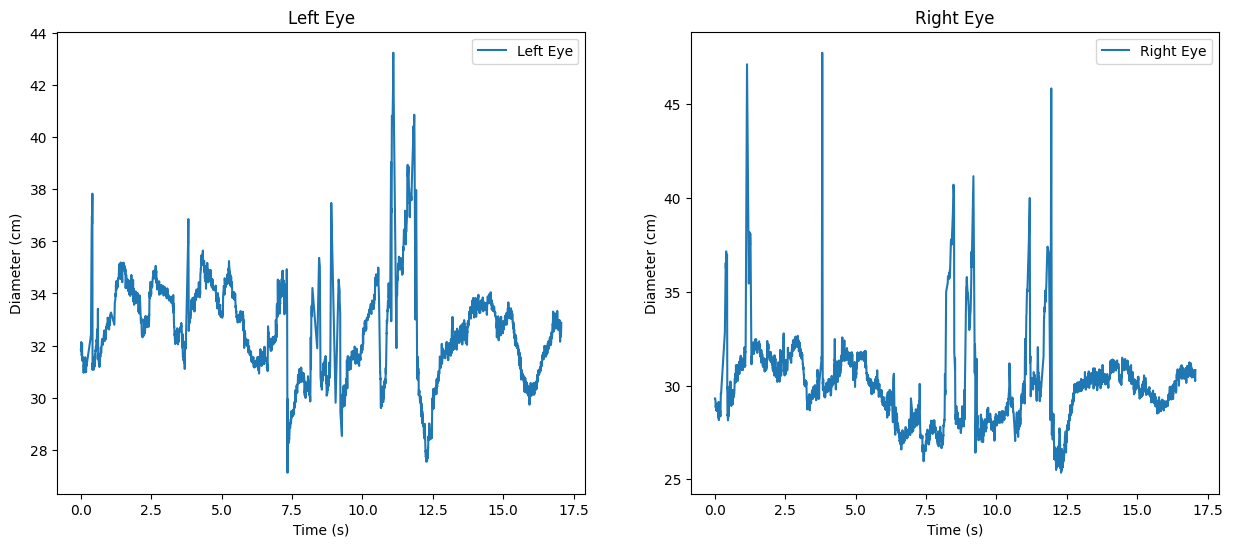

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(left_df['time'], left_df['diameter'], label='Left Eye')
axs[0].set_title('Left Eye')

axs[1].plot(right_df['time'], right_df['diameter'], label='Right Eye')
axs[1].set_title('Right Eye')

for ax in axs:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Diameter (cm)')
    ax.legend()

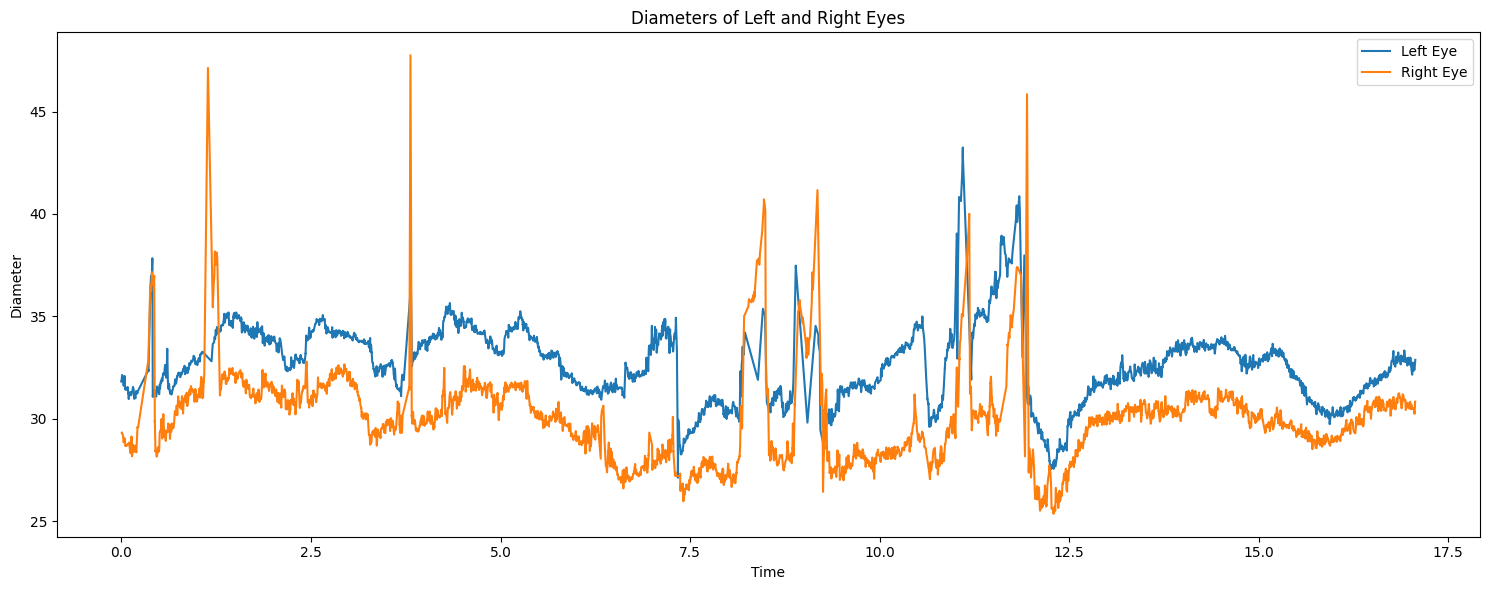

In [7]:
# Plot both smoothed diameters on the same graph
plt.figure(figsize=(15, 6))

plt.plot(left_df['time'], left_df['diameter'], label='Left Eye')
plt.plot(right_df['time'], right_df['diameter'], label='Right Eye')

plt.title('Diameters of Left and Right Eyes')
plt.xlabel('Time')
plt.ylabel('Diameter')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\jhund\AppData\Local\Temp\ipykernel_21772\287779325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['smoothed_diameter'] = left_df['diameter'].rolling(window=window).mean()
C:\Users\jhund\AppData\Local\Temp\ipykernel_21772\287779325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['smoothed_diameter'] = right_df['diameter'].rolling(window=window).mean()


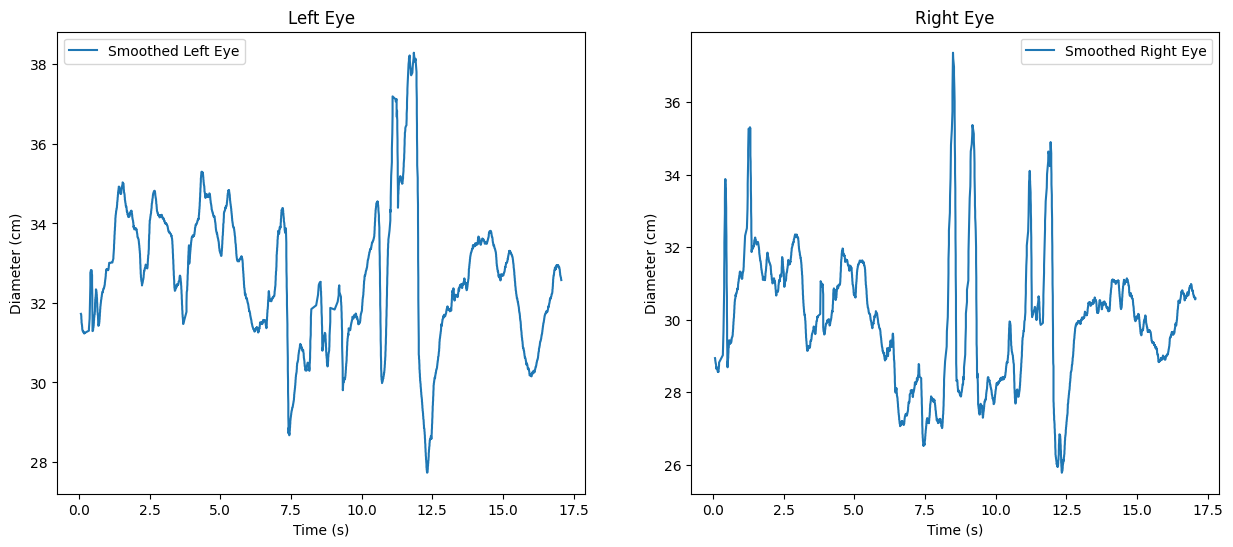

In [8]:
window = 20
left_df['smoothed_diameter'] = left_df['diameter'].rolling(window=window).mean()
right_df['smoothed_diameter'] = right_df['diameter'].rolling(window=window).mean()

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(left_df['time'], left_df['smoothed_diameter'], label='Smoothed Left Eye')
axs[0].set_title('Left Eye')

axs[1].plot(right_df['time'], right_df['smoothed_diameter'], label='Smoothed Right Eye')
axs[1].set_title('Right Eye')

for ax in axs:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Diameter (cm)')
    ax.legend()

C:\Users\jhund\AppData\Local\Temp\ipykernel_21772\3493357847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['smoothed_diameter'] = left_df['diameter'].rolling(window=window).mean()
C:\Users\jhund\AppData\Local\Temp\ipykernel_21772\3493357847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['smoothed_diameter'] = right_df['diameter'].rolling(window=window).mean()


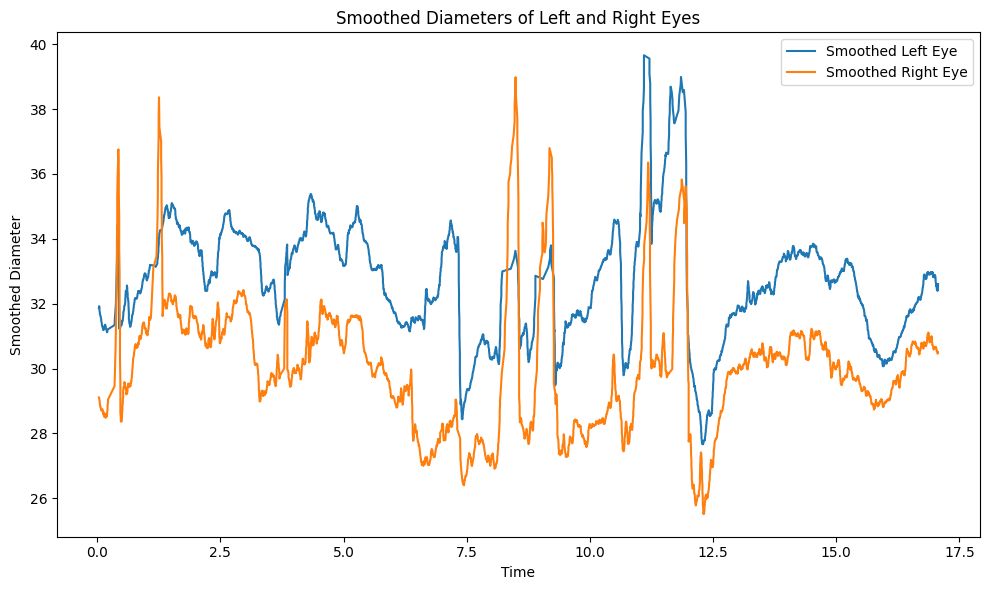

In [9]:
window = 10

# Calculate smoothed diameters
left_df['smoothed_diameter'] = left_df['diameter'].rolling(window=window).mean()
right_df['smoothed_diameter'] = right_df['diameter'].rolling(window=window).mean()

# Plot both smoothed diameters on the same graph
plt.figure(figsize=(10, 6))

plt.plot(left_df['time'], left_df['smoothed_diameter'], label='Smoothed Left Eye')
plt.plot(right_df['time'], right_df['smoothed_diameter'], label='Smoothed Right Eye')

plt.title('Smoothed Diameters of Left and Right Eyes')
plt.xlabel('Time')
plt.ylabel('Smoothed Diameter')
plt.legend()

plt.tight_layout()
plt.show()